# Project WriteUp: https://drive.google.com/drive/folders/1rV2kb16ewh_uNR_wgewvsUsA3EZ-I6Bn?usp=sharing

# **Team: ML Mavericks**
# **Team Members: Shubham Kothiya, Yugm Patel, Bharathi Vetukuri**

##HW Week 3 & Reading 4: Classification, Amalgamation , Confusion

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# **Load Datasets**
### This function loads three datasets from the given file paths.
### - `ds1`: Daily activity data
### - `ds2`: Sleep data
### - `ds3`: Heart rate data
### These datasets are read from CSV files stored in Google Drive.

In [ ]:
# Load datasets
def load_data():
    ds1 = pd.read_csv('/content/drive/MyDrive/Machine Learning/dailyActivity_merged.csv')
    ds2 = pd.read_csv('/content/drive/MyDrive/Machine Learning/sleepDay_merged.csv')
    ds3 = pd.read_csv('/content/drive/MyDrive/Machine Learning/heartrate_seconds_merged.csv')
    return ds1, ds2, ds3

# **Preprocess and Merge Datasets**
### This function preprocesses and merges the three datasets (`ds1`, `ds2`, `ds3`).
### - Converts date columns to datetime format.
### - Merges daily activity data (`ds1`) with sleep data (`ds2`) on `Id` and `ActivityDate`.
### - Aggregates heart rate data (`ds3`) to a daily level.
### - Merges the aggregated heart rate data with the combined dataset.

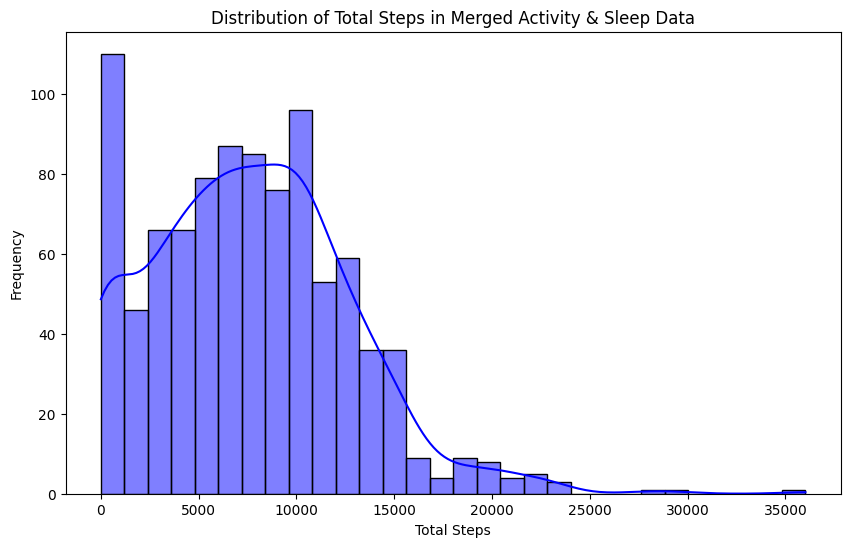

In [ ]:
# ===============================================
# 📌 Preprocess and Merge Datasets Function
# ===============================================
def preprocess_and_merge(ds1, ds2, ds3):
    # Merge ds1 and ds2
    ds1['ActivityDate'] = pd.to_datetime(ds1['ActivityDate'])
    ds2['SleepDay'] = pd.to_datetime(ds2['SleepDay'])
    merged_12 = pd.merge(ds1, ds2, left_on=['Id', 'ActivityDate'], right_on=['Id', 'SleepDay'], how='left')

    # Aggregate ds3 to daily level and merge
    ds3['DateTime'] = pd.to_datetime(ds3['Time'])
    ds3['Date'] = ds3['DateTime'].dt.date
    daily_hr = ds3.groupby(['Id', 'Date'])['Value'].agg(['mean', 'max', 'min']).reset_index()
    daily_hr['Date'] = pd.to_datetime(daily_hr['Date'])
    merged_all = pd.merge(merged_12, daily_hr, left_on=['Id', 'ActivityDate'], right_on=['Id', 'Date'], how='left')

    return merged_12, merged_all

# Call function to get merged datasets
merged_12, merged_all = preprocess_and_merge(ds1, ds2, ds3)

# ===============================================
# 📌 Now Run the Plots (Outside the Function)
# ===============================================

# 📊 Distribution of Total Steps
plt.figure(figsize=(10, 6))
sns.histplot(merged_12['TotalSteps'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Steps in Merged Activity & Sleep Data')
plt.xlabel('Total Steps')
plt.ylabel('Frequency')
plt.show()

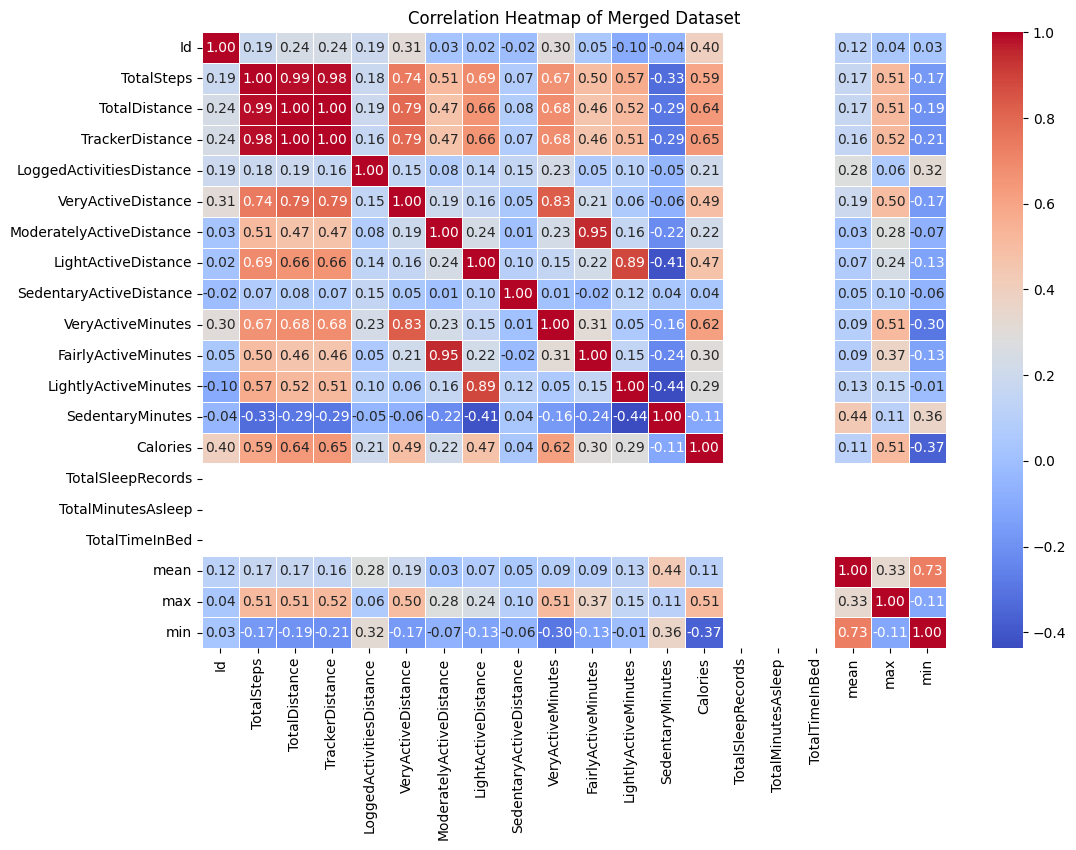

In [ ]:
# 📊 Correlation Heatmap of Merged Dataset
plt.figure(figsize=(12, 8))
sns.heatmap(merged_all.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Merged Dataset')
plt.show()

# **Define Activity Levels**
### This function categorizes users into different activity levels based on their activity minutes.
### - Uses `VeryActiveMinutes`, `FairlyActiveMinutes`, `LightlyActiveMinutes`, and `SedentaryMinutes` to determine activity level.
### - Assigns categories such as 'Very Active', 'Fairly Active', 'Lightly Active', and 'Sedentary'.
### - The highest applicable activity level is selected using `np.select()`.

<ipython-input-37-1da8b1b798a5>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=ds1['ActivityLevel'], order=['Very Active', 'Fairly Active', 'Lightly Active', 'Sedentary'], palette='coolwarm')


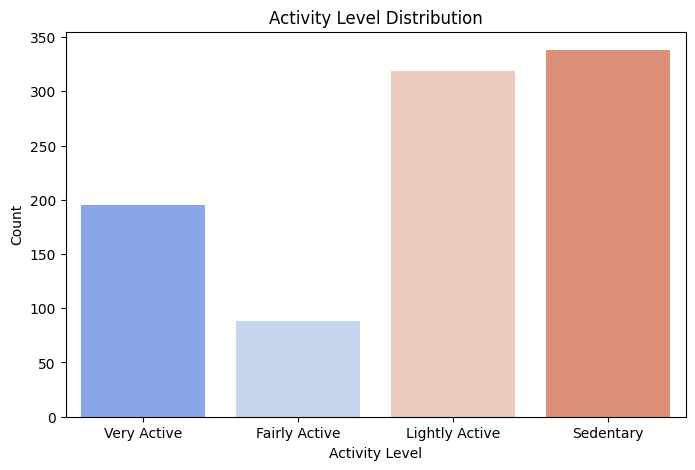

In [ ]:
# ===============================================
# 📌 Define Activity Levels Function
# ===============================================
def define_activity_levels(df):
    """
    Assigns activity level categories based on activity minutes.
    """
    conditions = [
        (df['VeryActiveMinutes'] > 40),
        (df['FairlyActiveMinutes'] > 30),
        (df['LightlyActiveMinutes'] > 200),
        (df['SedentaryMinutes'] > 0)
    ]
    choices = ['Very Active', 'Fairly Active', 'Lightly Active', 'Sedentary']
    df['ActivityLevel'] = np.select(conditions, choices, default='Sedentary')
    return df

# ===============================================
# 📌 Apply Function to Classify Activity Levels
# ===============================================
ds1 = define_activity_levels(ds1)

# ===============================================
# 📌 Plot: Activity Level Distribution
# ===============================================
plt.figure(figsize=(8, 5))
sns.countplot(x=ds1['ActivityLevel'], order=['Very Active', 'Fairly Active', 'Lightly Active', 'Sedentary'], palette='coolwarm')
plt.title('Activity Level Distribution')
plt.xlabel('Activity Level')
plt.ylabel('Count')
plt.show()

# **Prepare Features and Target**
### This function selects relevant features (`X`) and defines the target variable (`y`) for model training.
### - Includes activity-related features such as `TotalSteps`, `TotalDistance`, and `ActivityMinutes`.
### - Adds sleep data (`TotalMinutesAsleep`, `TotalTimeInBed`) if available.
### - Includes heart rate statistics (`mean`, `max`, `min`) if present.
### - The target variable (`y`) is set as `ActivityLevel`.

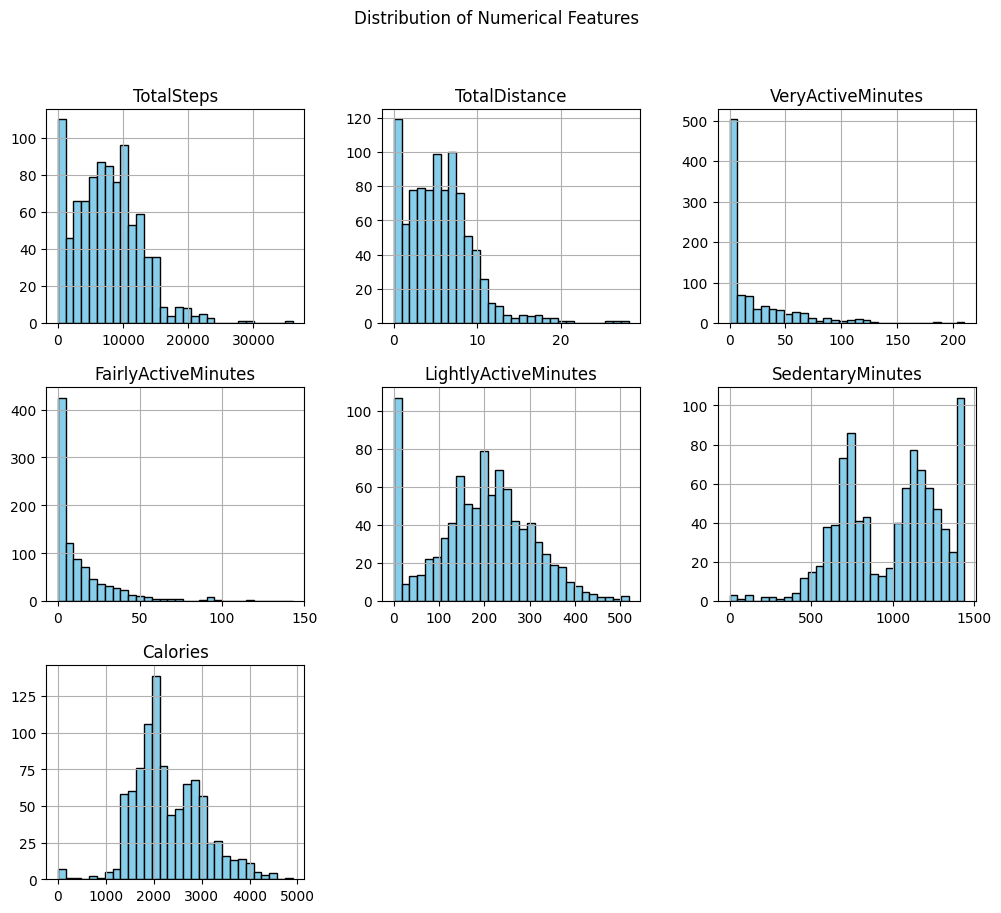

In [ ]:
# ===============================================
# 📌 Define Prepare Features Function
# ===============================================
def prepare_features(df):
    """
    Extracts relevant features (X) and target variable (y) for training models.
    """
    features = ['TotalSteps', 'TotalDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
                'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

    if 'TotalMinutesAsleep' in df.columns:
        features.extend(['TotalMinutesAsleep', 'TotalTimeInBed'])
    if 'mean' in df.columns:
        features.extend(['mean', 'max', 'min'])

    X = df[features]
    y = df['ActivityLevel']
    return X, y

# ===============================================
# 📌 Apply Feature Preparation
# ===============================================
X, y = prepare_features(ds1)

# ===============================================
# 📌 Plot 1: Distribution of Numerical Features
# ===============================================
X.hist(figsize=(12, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle('Distribution of Numerical Features')
plt.show()

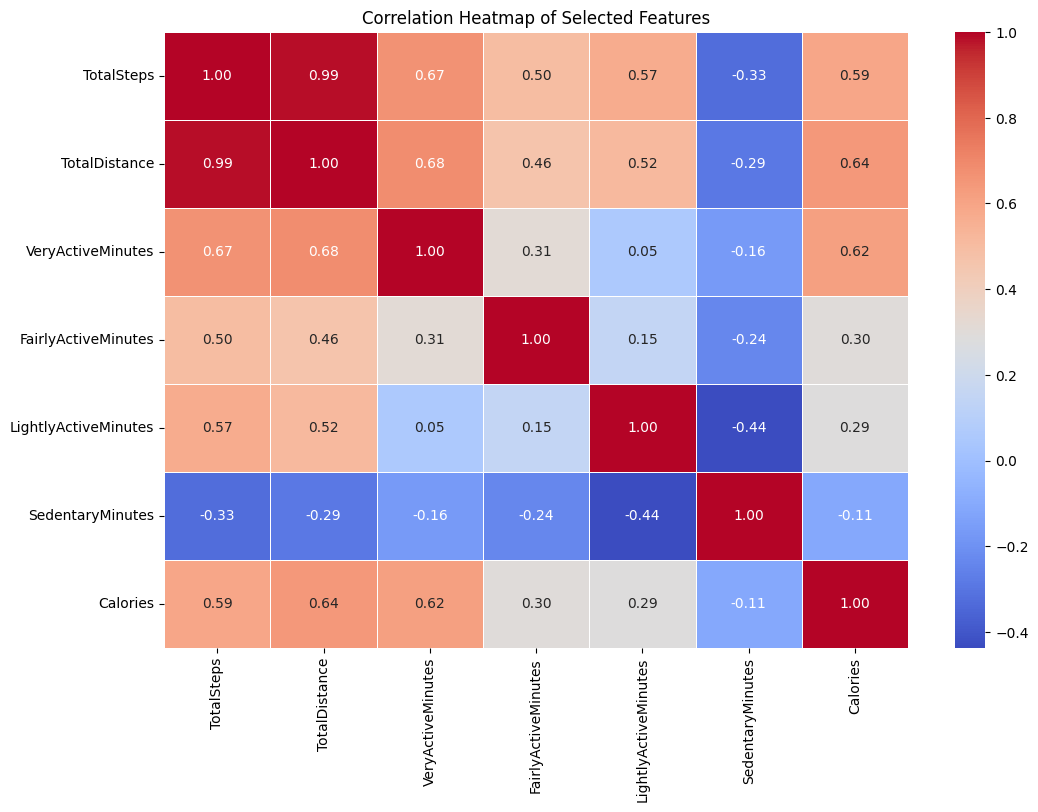

In [ ]:
# ===============================================
# 📌 Plot 2: Correlation Heatmap of Features
# ===============================================
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

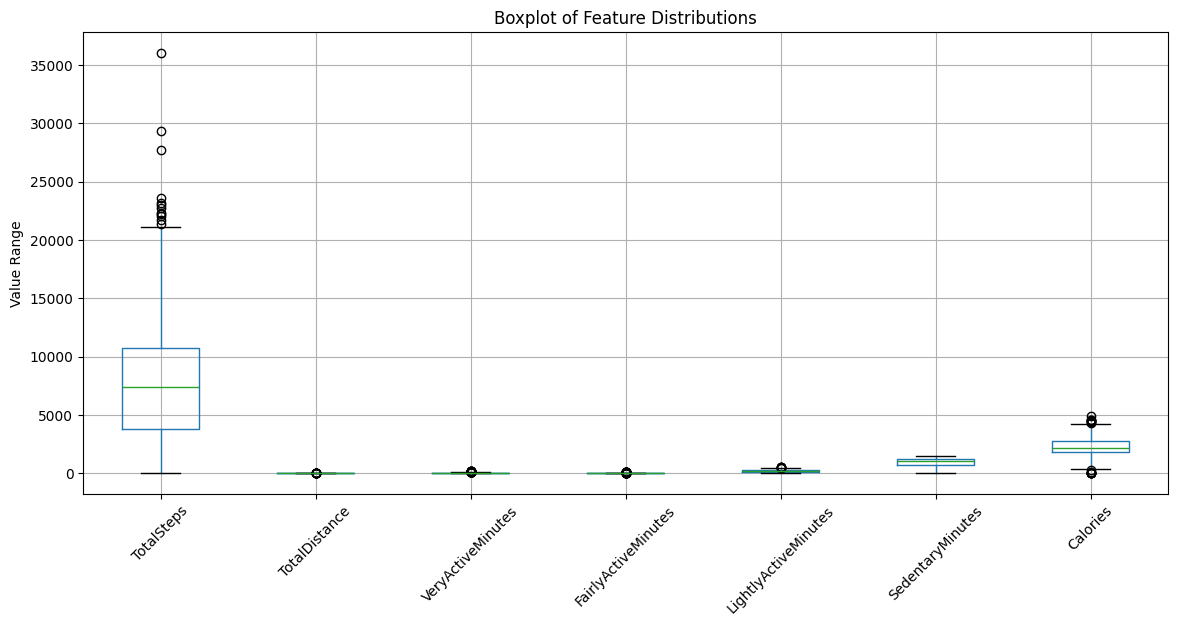

In [ ]:
# ===============================================
# 📌 Plot 3: Boxplot of Feature Distributions
# ===============================================
plt.figure(figsize=(14, 6))
X.boxplot(rot=45, grid=True)
plt.title('Boxplot of Feature Distributions')
plt.ylabel('Value Range')
plt.show()

# **Train and Evaluate Model**
### This function trains a given model on the provided dataset and evaluates its performance.
### - Splits the dataset into training and testing sets.
### - Scales the feature set using `StandardScaler` to improve model performance.
### - Trains the model using the training data.
### - Makes predictions on the test set.
### - Calculates and returns key evaluation metrics: Accuracy, Precision, Recall, and F1-Score.

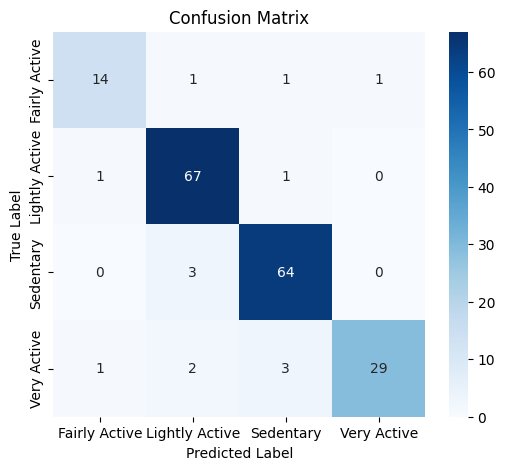

(0.925531914893617, 0.9265001488981536, 0.925531914893617, 0.9246091023444758)

In [ ]:
# Train and evaluate the model
def train_evaluate_model(X, y, model, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # 📊 Corrected Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(set(y_test))  # Get unique class labels from y_test

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return accuracy, precision, recall, f1
train_evaluate_model(X, y, model, test_size=0.2)

# **Muller Loop Implementation**
### This function evaluates model performance by incrementally increasing the training data size.
### - Splits data into training and testing sets.
### - Scales the feature set using `StandardScaler` to ensure consistency.
### - Iterates over different training set sizes, from 10% to 100% of available training data.
### - Trains the model on progressively larger subsets and evaluates both training and testing scores.
### - Returns the train sizes, training scores, and test scores for visualization.

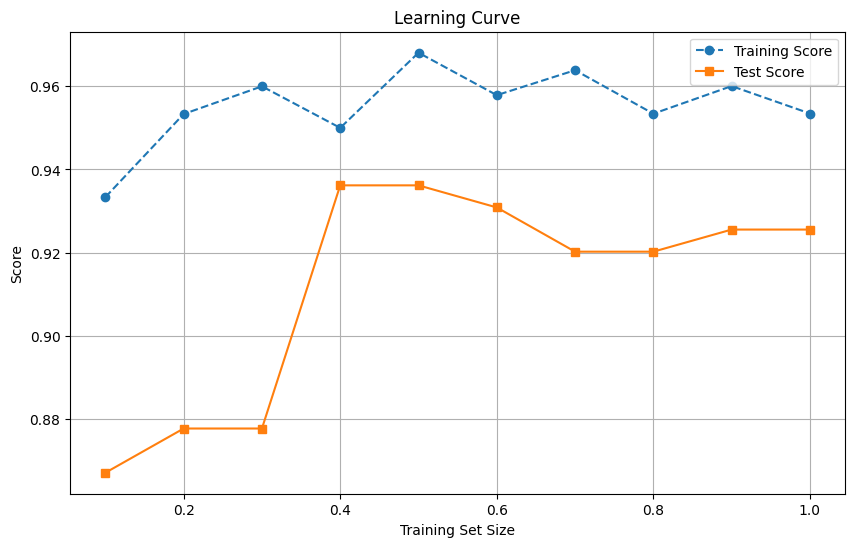

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [0.9333333333333333,
  0.9533333333333334,
  0.96,
  0.95,
  0.9680851063829787,
  0.9578713968957872,
  0.9638783269961977,
  0.9534109816971714,
  0.9600591715976331,
  0.9534574468085106],
 [0.8670212765957447,
  0.8776595744680851,
  0.8776595744680851,
  0.9361702127659575,
  0.9361702127659575,
  0.9308510638297872,
  0.9202127659574468,
  0.9202127659574468,
  0.925531914893617,
  0.925531914893617])

In [ ]:
# Muller loop implementation
def muller_loop(X, y, model, n_points=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    train_sizes = np.linspace(0.1, 1.0, n_points)
    train_scores = []
    test_scores = []

    for size in train_sizes:
        n_samples = int(len(X_train_scaled) * size)
        model.fit(X_train_scaled[:n_samples], y_train[:n_samples])
        train_scores.append(model.score(X_train_scaled[:n_samples], y_train[:n_samples]))
        test_scores.append(model.score(X_test_scaled, y_test))

    # 📊 Plot Learning Curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, label='Training Score', marker='o', linestyle='dashed')
    plt.plot(train_sizes, test_scores, label='Test Score', marker='s', linestyle='solid')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_sizes, train_scores, test_scores
muller_loop(X, y, model, n_points=10)

# **Load and Preprocess Data**
### This block loads the datasets, handles missing values, and prepares the data for modeling.

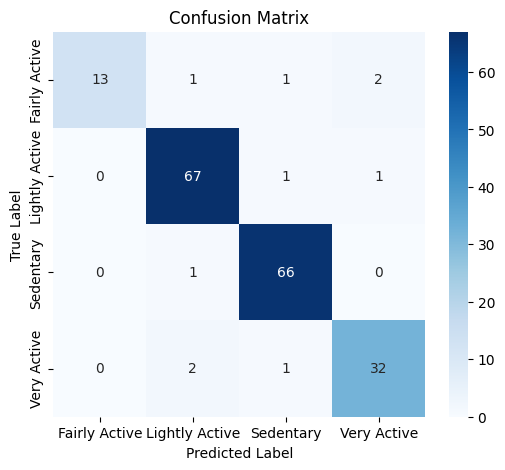

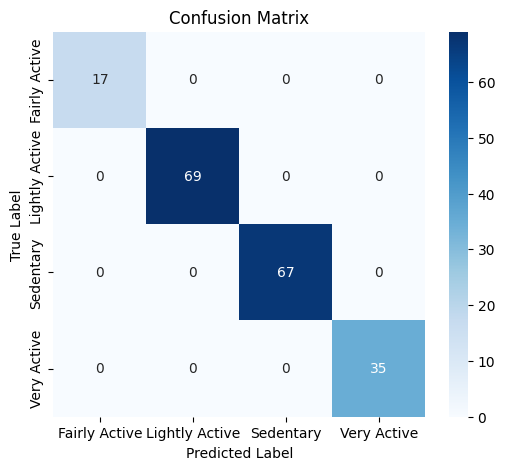

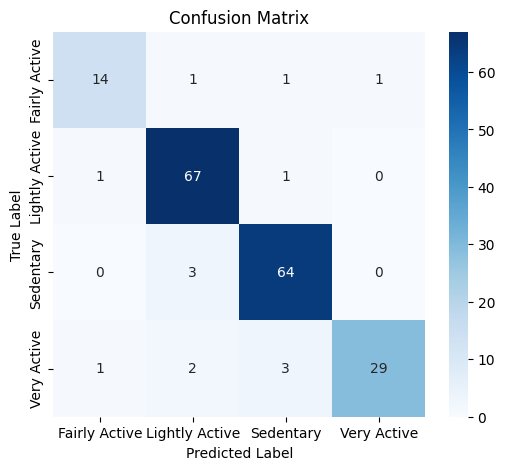

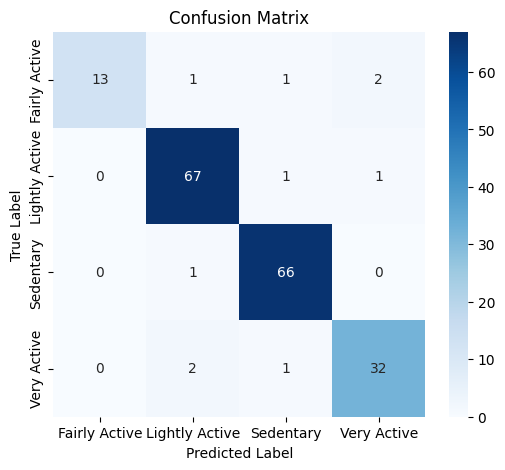

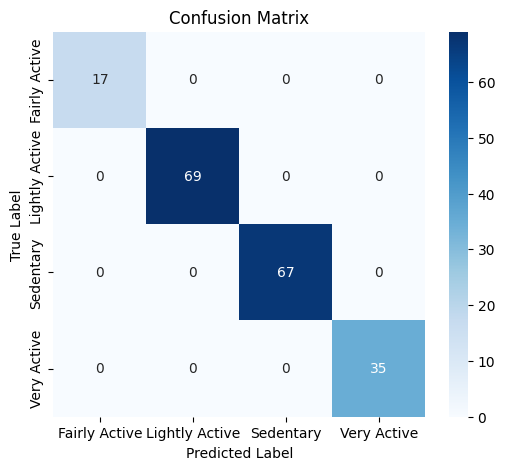

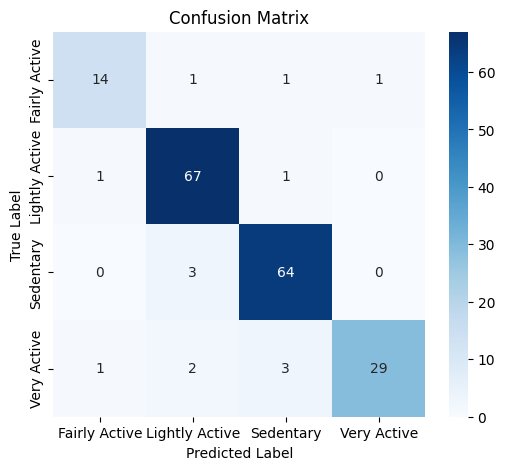

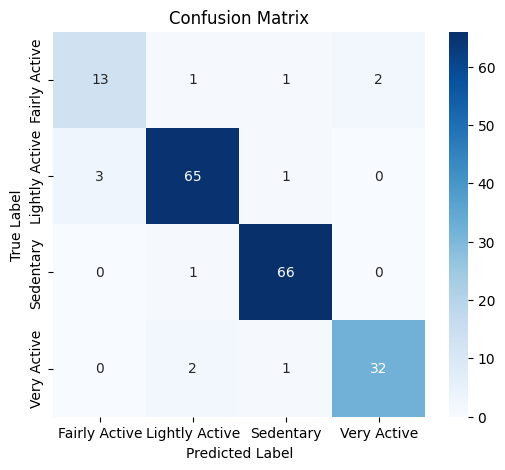

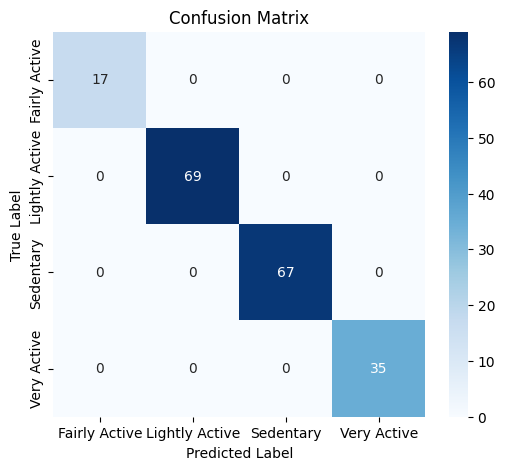

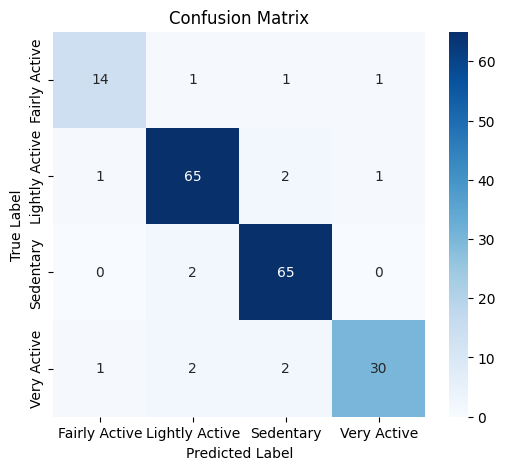

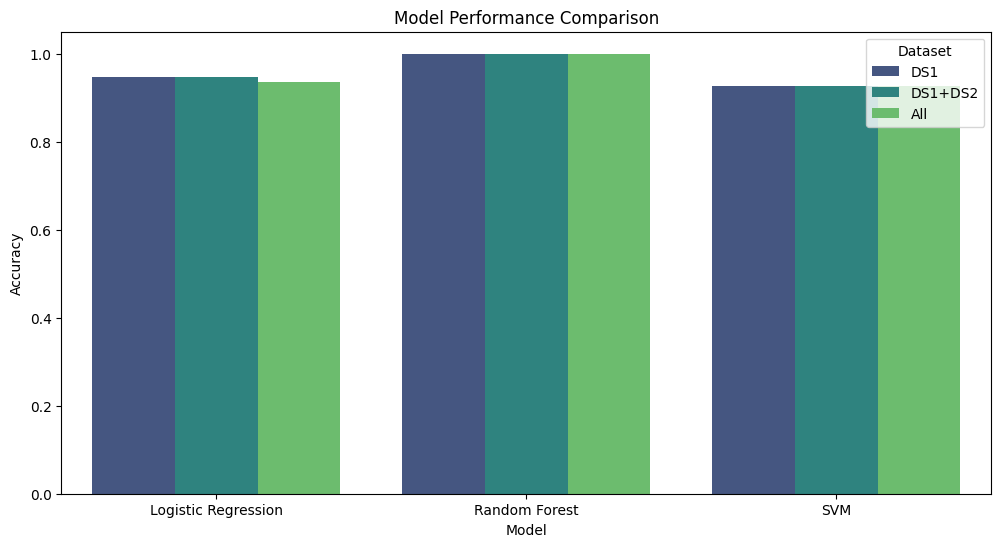

In [ ]:
# Load datasets
ds1, ds2, ds3 = load_data()

# Handle date parsing issue
ds2['SleepDay'] = pd.to_datetime(ds2['SleepDay'], format='%m/%d/%Y', errors='coerce')

# Preprocess and merge datasets
merged_12, merged_all = preprocess_and_merge(ds1, ds2, ds3)

datasets = [ds1, merged_12, merged_all]
dataset_names = ['DS1', 'DS1+DS2', 'All']

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

results = []

for i, df in enumerate(datasets):
    df = define_activity_levels(df)
    X, y = prepare_features(df)

    # **Step 1: Drop Columns That Are Entirely NaN**
    X = X.dropna(axis=1, how='all')  # Removes columns where all values are NaN

    # **Step 2: Impute Missing Values for Remaining Columns**
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # **Step 3: Convert back to DataFrame with correct column names**
    X = pd.DataFrame(X_imputed, columns=X.columns)

    for model_name, model in models.items():
        accuracy, precision, recall, f1 = train_evaluate_model(X, y, model)
        results.append({
            'Model': model_name,
            'Dataset': dataset_names[i],
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# 📊 Plot Model Performance Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=results_df, palette='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='Dataset')
plt.show()

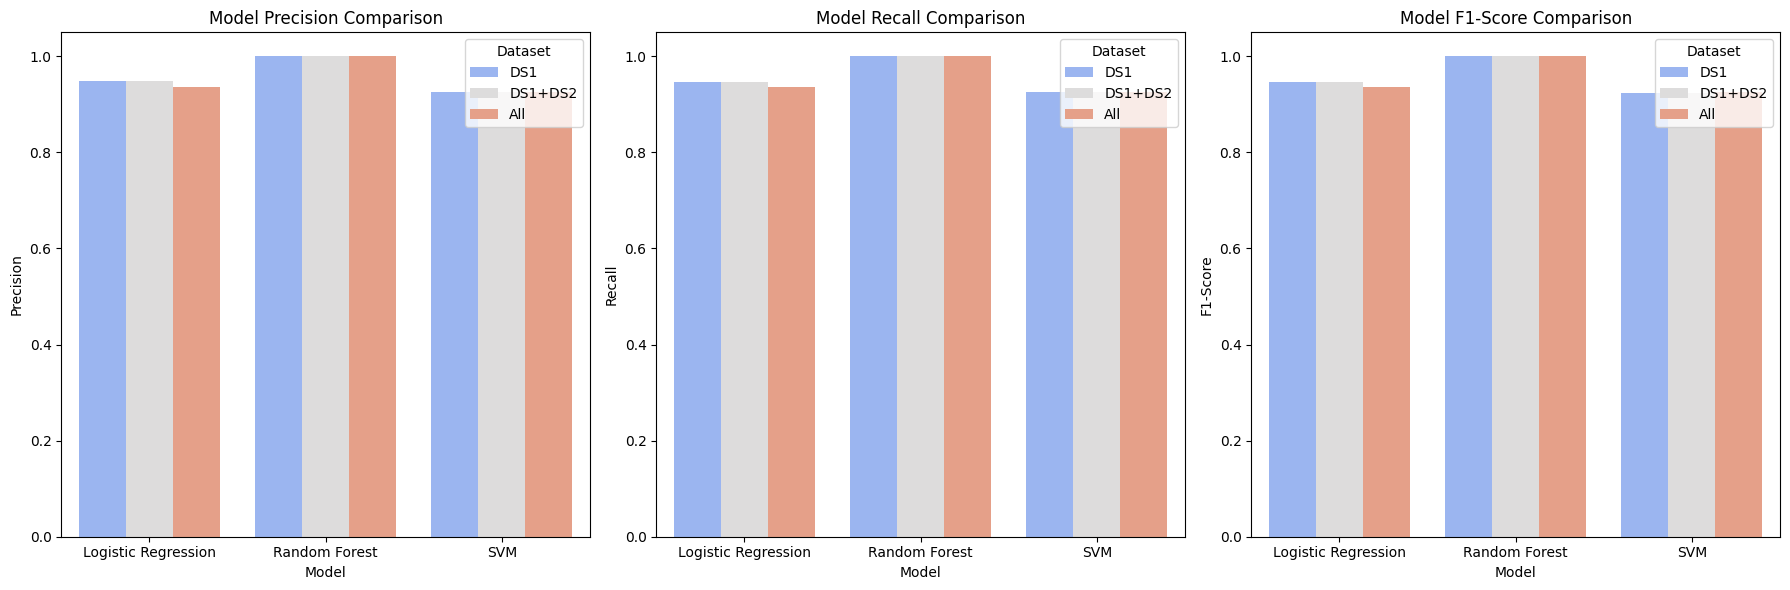

In [ ]:
# 📊 Plot Precision, Recall, and F1-Score
metrics = ['Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    plt.sca(axes[i])
    sns.barplot(x='Model', y=metric, hue='Dataset', data=results_df, palette='coolwarm')
    plt.title(f'Model {metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.legend(title='Dataset')

plt.tight_layout()
plt.show()

# **Create and Display Results Table**
### This block converts the collected model evaluation results into a structured DataFrame
### and prints it in a readable format.

In [ ]:
# Create results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

              Model Dataset  Accuracy  Precision   Recall  F1-Score
Logistic Regression     DS1  0.946809   0.947870 0.946809  0.945774
      Random Forest     DS1  1.000000   1.000000 1.000000  1.000000
                SVM     DS1  0.925532   0.926500 0.925532  0.924609
Logistic Regression DS1+DS2  0.946809   0.947870 0.946809  0.945774
      Random Forest DS1+DS2  1.000000   1.000000 1.000000  1.000000
                SVM DS1+DS2  0.925532   0.926500 0.925532  0.924609
Logistic Regression     All  0.936170   0.935323 0.936170  0.935570
      Random Forest     All  1.000000   1.000000 1.000000  1.000000
                SVM     All  0.925532   0.925389 0.925532  0.924875


# **Save Model Evaluation Results to CSV**
### This block saves the results DataFrame to a CSV file for future analysis and reporting.

In [ ]:
# Save results to CSV
results_df.to_csv('classification_results.csv', index=False)